# 1 - Introduction to representing molecules quantiatively

In this lesson we will learn how to take molecules and represent them quantiatively. 

Learning outcomes: 
- What is a Structure Activity Relationship (SAR)?
- The problem with qualitative models
- Example of a simple but effective QSAR
- Working quantitatively
- Developing our first simple QSAR model.
- Improving the model

### What is a Structure Activity Relationship (SAR)?

A Structure Activity Relationship (SAR) is the relationship between the chemical structure of a molecule and its biological activity. The SAR concept has been used qualitatively by medicinal chemists for decades and works a little like this example:
     
- "Positive charge in this area is good as it binds the free Serine oxygen electrons, but we also need a small compound for the small binding pocket". 

![SAR](lib/imgs/1_SAR.png)

A SAR is often used in drug discovery to guide the acquisition or synthesis of desirable new molecules. This is often synonymous with a chemists intuition or experience. 

### The problem with qualitative models
The problem with relying purely on qualitative SAR's is that any given medicinal chemist can give their opinion on maybe 1 molecule per minute, that's only 2400 in a 40 hour working week. Often compound libraries have millions of members! This is why the Q in QSAR is so important, codifying SAR models as quantitative statistical models allows us to take advantage of the speed, scalability and cost of shifting compute to silicon.

### Example of a simple but effective QSAR
Anaesthetics are strange compounds, they put humans into a sleep-like state useful for surgery. Although we still do not know exactly how the drugs we have identified do this, early research by Meyer and Overton identified that compounds that were more soluble in Olive oil were more potent anaesthetics. They measured the Olive oil:Gas partition coefficient (10 here would meant 10 parts of drug x are present in olive oil, to 1 part in gas at 37 celcius, think of this as lipophilicity) of several anaesthetic drugs and the correlation is clear as day. A strong linear relationship.
![1_m_o]("lib/imgs/2_meyer_overton.png")

This is a simple QSAR model, but this model relies on us having experimentally measured data which is expensive to measure. Can we overcome this with se of statistics and other QSAR concepts?

### Working quantitatively
This process requires two key procedures, we need to:
- Represent molecules as numeric vectors, allowing us to apply mathematical functions
- Develop models that act on molecular vectors to return predicted values

A general approach to deriving molecular vectors is to use descriptors, cheap to caculate values you can easily derive. Examples could be to simply add up the number of atoms present, and calculate the molecular weight of the compound.

To do this we need some representation of the molecules in data, the typical go-to is the SMILES string e.g. Ritonavir a HIV protease inhibitor has the smiles string CC(C)C1=NC(=CS1)CN(C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CC2=CC=CC=C2)C[C@@H]([C@H](CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O

To handle the compute we will need to choose a framework. Do we code in Java, Python, R. What Packages should we use? etc Here we will code in Python, and just use a single package for now rdkit.

Let's quickly parse Ritonavir and calculate its molecular weight

In [5]:
# Installing packages, we will use these throughout but you can see rdkit in there
# remove the "#" in the below line and run the cell
# ! python3 -m pip install pandas numpy xgboost sklearn matplotlib rdkit deepchem mordred tensorflow scipy seaborn opencv-python

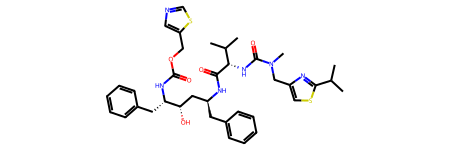

In [6]:
# Parse the Ritonavir
from rdkit import Chem
from rdkit.Chem import AllChem
smiles = 'CC(C)C1=NC(=CS1)CN(C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CC2=CC=CC=C2)C[C@@H]([C@H](CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O'
mol  = AllChem.MolFromSmiles(smiles)

# Draw Ritonavir
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
mol

In [7]:
# Calculate the molecular weight and number of atoms
from rdkit.Chem.Descriptors import ExactMolWt, fr_amide, NumHDonors, NumValenceElectrons
import numpy as np
n_atoms = mol.GetNumAtoms()
mol_weight = ExactMolWt(mol)

print('Ritonavir contains ' + str(n_atoms) + ' atoms')
print('Ritonavir has a molecualr weight of '  + str(mol_weight))

print('A simple 2-member numeric vector of Ritonavir would then be:')
np.array([np.float16(n_atoms),np.float16(mol_weight)])

Ritonavir contains 50 atoms
Ritonavir has a molecualr weight of 720.312760636
A simple 2-member numeric vector of Ritonavir would then be:


array([ 50. , 720.5], dtype=float16)

### Developing our first simple QSAR model.

Knowing that the activity of an anaesthetic is intimitely related to its lipophilicity, we can take some known lipophilicty data and try to predict that as a surrogate for anaesthetic effecicy. ( this will be a higher throughput test than assessing potency in mouse induced-sleeep experiments).

Aim: Can we predict the LogP (an octanol-water partition coefficient used in more modern times) of several compounds. We will treat this like a typical machine learning problem, take some of the data and train a model, then assess its predictive power on some reserve test data the model has never seen.

- So we need some data. A set of compounds each with one or several labels we want to predict. 
This has been pre-downloaded and lightly cleaned from CHEMBL, a large data resource of molecular properties and activities. THis activity makes us of 100 datapoints from the CHBMEL document ![CHEMBL635482](https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL635482) 

- The framework we will use is rdkit, we will also use the pandas package to handle the data

- sklearn is a package that will let us develop the predictive model of LogP

- To assess the model performance we use use the test:train split method. Training (inferring the optimal model parameters) with a portion of data, then assessing model predictive performance with a set of data it has never seen.

In [8]:
# read data
import pandas as pd
df = pd.read_table('data.tsv')
# print the header, is this looking ok?
df.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value
0,CHEMBL428358,CC(=O)OC1OC(C)C(OC(C)=O)C(OC(C)=O)C1NC(=O)N(CC...,LogP,1.32
1,CHEMBL274417,O=NN(CCCl)C(=O)NC1CCSCC1,LogP,2.07
2,CHEMBL268495,O=NN(CCCl)C(=O)NC1CC2CCC1C2,LogP,2.98
3,CHEMBL2094020,O=NN(CCCl)C(=O)N[C@H]1C(O)O[C@H](CO)[C@@H](O)[...,LogP,-0.66
4,CHEMBL274127,O=NN(CCCl)C(=O)NC1C=CCCC1,LogP,2.45


In [9]:
### for each molecule calculate some simple descriptors that may be informative of LogP
# read the set of molecules
mols = [Chem.MolFromSmiles(smi) for smi in df.Smiles]

# for each mol calculate some key descriptors and add as columns to this dataframe
df['n_atoms'] = [m.GetNumAtoms() for m in mols]
df['mol_weight'] = [ExactMolWt(m) for m in mols]
df['fr_amide'] = [fr_amide(m) for m in mols]
df['NumHDonors'] = [NumHDonors(m) for m in mols]
df['NumValenceElectrons'] = [NumValenceElectrons(m) for m in mols]
df

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,n_atoms,mol_weight,fr_amide,NumHDonors,NumValenceElectrons
0,CHEMBL428358,CC(=O)OC1OC(C)C(OC(C)=O)C(OC(C)=O)C1NC(=O)N(CC...,LogP,1.320,28,423.104457,2,1,158
1,CHEMBL274417,O=NN(CCCl)C(=O)NC1CCSCC1,LogP,2.070,15,251.049525,2,1,86
2,CHEMBL268495,O=NN(CCCl)C(=O)NC1CC2CCC1C2,LogP,2.980,16,245.093104,2,1,90
3,CHEMBL2094020,O=NN(CCCl)C(=O)N[C@H]1C(O)O[C@H](CO)[C@@H](O)[...,LogP,-0.660,20,313.067678,2,5,116
4,CHEMBL274127,O=NN(CCCl)C(=O)NC1C=CCCC1,LogP,2.450,15,231.077454,2,1,84
...,...,...,...,...,...,...,...,...,...
96,CHEMBL13072,O=NN(CCF)C(=O)NC1CCCCC1,LogP,2.250,15,217.122655,2,1,86
97,CHEMBL11985,CC12CC3(C)CC(C)(C1)CC(NC(=O)N(CCCl)N=O)(C2)C3,LogP,5.575,22,327.171355,2,1,124
98,CHEMBL11976,CC(C)(Cc1ccccc1)NC(=O)N(CCCl)N=O,LogP,3.420,19,283.108754,2,1,104
99,CHEMBL2051749,CC(=O)O[C@H]1CCCC[C@@H]1NC(=O)N(CCCl)N=O,LogP,2.560,19,291.098584,2,1,108


Great! Now for each molecule we have a label (the LogP), and a set of descriptors.
Let's build a model!

In [10]:
# we will use the sklearn package to extend our codebase into the ML territory
from sklearn.model_selection import train_test_split

# let's clean this dataset and just keep the columns we need.
x = df.iloc[:, [4,5,6,7]]       # molecular vectors
y = df.iloc[:,3]                # LogP

# split the data to allow trainig and predictive assessment
x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=123) 

In [11]:
# Random forest is a good default model to choose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# fit the model, i.e. train
model = RandomForestRegressor()
model.fit(x_train, y_train)

# for the test molecules, predict their LogP
y_test_pred = model.predict(x_test)

# model predictive performance metrics
mse = mean_squared_error(y_pred= y_test_pred, y_true=y_test)
r2 = r2_score(y_pred= y_test_pred, y_true=y_test)
print("The mean square error is: ", mse)
print("The correlation coefficient r2 is: ", r2)

The mean square error is:  1.6792003198903032
The correlation coefficient r2 is:  0.18414734960521595


So now we have a machine learning model that takes a molecule and predicts it's LogP!
The perfomance metrics tell us that on average the model is circa 1.5 LogP off the true value, this is only partially useful though, what's the LogP range of the data we fed in etc? Always plot. Let's look at the test set correlation now, does it look meaningful?

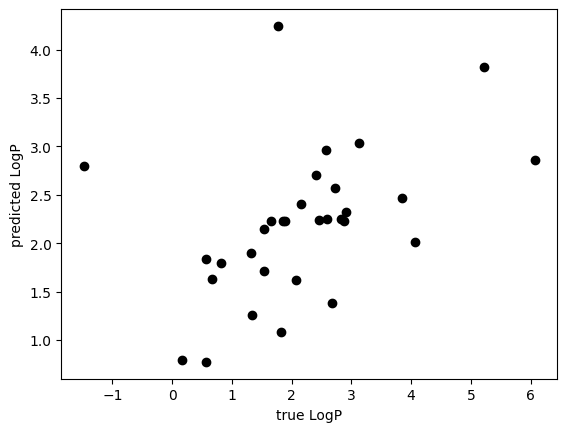

In [12]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_test_pred, 'o', color='black');
plt.xlabel('true LogP');
plt.ylabel('predicted LogP');

There you have it. It's by no means the prettiest or best model, but the model does appear to have some predictive power as theres certainly a correlation between predicted ans measured LogP from this data.

### Improving the model

This was a bit of a toy example, we only chose a handful of descriptors but typically one would use many more. In a typical QSAR workflow you may try many descriptors, many ML algorithms (RF, xgb, SVM etc) and various combinations of other factors. For now let's see how expanding our set of descriptors impacts the predictive performance even with only 100 datapoints total.

In [14]:
# the deepchem package is helfpul as a way to access various descriptors
import deepchem as dc
from multiprocessing import Pool
import os

def smiles_2_rdkitDescr(smiles):
    featurizer = dc.feat.RDKitDescriptors()
    return(featurizer(smiles).flatten())

# rdkit descriptors - 208 total
with Pool(processes=os.cpu_count()) as p:
    x_rdkit = np.stack(p.map(smiles_2_rdkitDescr, df.Smiles.values))



array([ 1.23236585e+01,  1.23236585e+01,  7.52158973e-02, -1.39156321e+00,
        2.02256627e-01,  4.23806000e+02,  4.01630000e+02,  4.23104457e+02,
        1.58000000e+02,  0.00000000e+00,  3.40516605e-01, -4.56010998e-01,
        4.56010998e-01,  3.40516605e-01,  1.03571429e+00,  1.57142857e+00,
        2.03571429e+00,  3.54956637e+01,  9.96528058e+00,  2.50434334e+00,
       -2.43446219e+00,  2.27133829e+00, -2.66061543e+00,  6.17647873e+00,
       -2.60210916e-01,  2.57396081e+00,  3.23831492e+00,  6.17564097e+02,
        2.14303569e+01,  1.57475912e+01,  1.65035201e+01,  1.30986619e+01,
        8.24640905e+00,  8.78093153e+00,  5.83616867e+00,  6.21413315e+00,
        3.58805557e+00,  3.75708642e+00,  2.57792088e+00,  2.73802920e+00,
       -2.47000000e+00,  2.57396081e+00,  2.35691696e+01,  1.07584818e+01,
        6.60318622e+00,  1.65220709e+02,  2.42642404e+01,  6.04184083e+00,
        1.22079328e+01,  6.29002673e+00,  0.00000000e+00,  2.39390304e+01,
        1.43836116e+01,  

rather than storethe molecular vectors in a pandas dataframe, now it's a numpy array.


Let's take a look at the first molecules 1D array "vector" theres 208 floating point numbers.


In [ ]:
x_rdkit[0] 

Now we just copy the process from earlier, but generate a new set of test and train data

In [15]:
# split the data to allow trainig and predictive assessment
x_train, x_test, y_train, y_test = train_test_split(
        x_rdkit, y, test_size=0.3, random_state=123) 

# fit the model, i.e. train
model = RandomForestRegressor()
model.fit(x_train, y_train)

# for the test molecules, predict their LogP
y_test_pred = model.predict(x_test)

# model predictive performance metrics
mse = mean_squared_error(y_pred= y_test_pred, y_true=y_test)
r2 = r2_score(y_pred= y_test_pred, y_true=y_test)
print("The mean square error is: ", mse)
print("The correlation coefficient r2 is: ", r2)

The mean square error is:  0.2194505636255663
The correlation coefficient r2 is:  0.8933782218572686


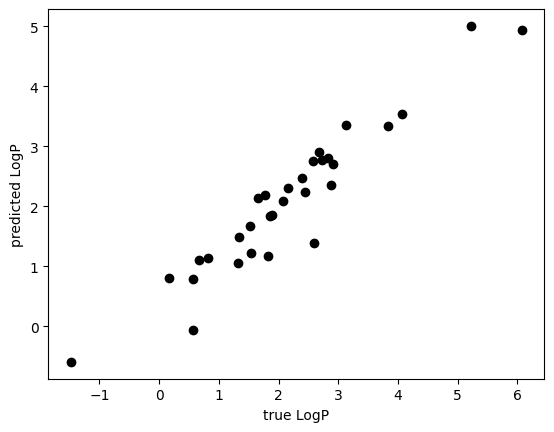

In [16]:
plt.plot(y_test, y_test_pred, 'o', color='black');
plt.xlabel('true LogP');
plt.ylabel('predicted LogP');

Wowzers! This is looking pretty fantastic right?

By including further, or potentially much more informative molecular descriptors our LogP model has improved dramatically. 

What's actually going on here is that the RDkit set of descriptors actually includes several cheap calculations that attempts to return a LogP, such as ALogP and SLogP. Which means you can get in the right ballpark quite easily for a random given molecule.

# Summary
This has been an introduction to QSAR modelling and the importance of molecular representation as a factor to improving predictability. Further notebooks will inue down this path introducing other machine learning algorithms, approaches etc.

